## Section 0: import and function definitions

In [1]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import pygsp
from pygsp import graphs, filters
import networkx as nx
import pickle
import matplotlib.cm as cm
import pylab
import os

In [2]:
%matplotlib inline

In [3]:
## data folders
data_folder = '../data/'
plots_folder = '../plots/'

In [4]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
def load_object(filename):
    with open(filename, 'rb') as input:
        obj = pickle.load(input)
    return obj

In [5]:
def build_signal(G, views):
    '''
    Given the raw counts based on page views, build the signal on the graph
    :param G:
    :param views:
    :return: dict node to signal (ratio between views before and after the event)
    '''
    views_graph = {}
    for node in G.nodes():
        if node not in views.keys():
            views_graph[node] = 1
            continue
        if len(views[node]) < 2 or views[node][0][0] == 0:
            views_graph[node] = 1
            continue

        try:
            # TODO: assert that dates are before & after the event            
            views_graph[node] = views[node][-1][0] / views[node][0][0]
        except IndexError:
            print(f'IndexError for node {node}')
            views_graph[node] = 1

    return views_graph

In [6]:
def hop_map(distance_source):
    '''
    function that maps number of hops to a list of pages that can be reachable within n_hops from stan lee
    :param distance_source: the number of hops to make from source
    :return: n_hops_to_links
    '''
    hop_links = {}
    for item in distance_source:
        n_hops = distance_source[item]
        if (n_hops in hop_links):
            hop_links[n_hops].append(item)
        else:
            hop_links[n_hops] = [item]
    return hop_links


In [7]:
def assign_coordinates_colours(n_hops_to_links, signal):
    '''
    
    :param n_hops_to_links: dict that maps n_hops to the links
    :param signal: dict that maps article to their signal
    :return: the coordinates of the points and the signal
    '''
    R = list(n_hops_to_links.keys())  #radius
    T = [len(n_hops_to_links[hop]) for hop in R] # how many points per circle
    points = []
    points_signal = []
    r_init = 0
    idx = 0
    for r, t in rtpairs(R, T):
        if r == r_init:
            article = n_hops_to_links[r][idx]
            idx = idx+1
        else:
            article = n_hops_to_links[r][0]
            r_init = r
            idx = 1
        points.append(np.array([r * np.cos(t), r * np.sin(t)]))
        points_signal.append(signal[article])
    points = np.array(points)
    return points, points_signal

In [8]:
def rtpairs(r, n):
    for i in range(len(r)):
        for j in range(n[i]):
            yield r[i], j*(2 * np.pi / n[i])

In [9]:
articles = [
    'Stephen Hawking',
    'Stan Lee',
    'Alan Rickman',
]

In [10]:
def article_to_filename(name):
    return ''.join(c for c in name if c.isalnum())

## Section 1: loading the signal and plotting it

In [11]:
graphs = [nx.read_gpickle(os.path.join(data_folder, 'G_'+article_to_filename(a)+'.gpickle')) for a in articles]
views = [load_object(os.path.join(data_folder, '1_'+article_to_filename(a)+'_signal.pkl')) for a in articles]

In [12]:
signals = [build_signal(G, v) for G,v in zip(graphs, views)]

In [13]:
# distances to the root node
distances = [nx.shortest_path_length(G, source=article) for G, article in zip(graphs, articles)]
for dist,article in zip(distances, articles):
    print(f'{article} graph: nodes are max {max(dist.values())} hops away from "{article}"')

Stephen Hawking graph: nodes are max 6 hops away from "Stephen Hawking"
Stan Lee graph: nodes are max 5 hops away from "Stan Lee"
Alan Rickman graph: nodes are max 5 hops away from "Alan Rickman"


/Users/mi/miniconda3/envs/ntds_2018/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


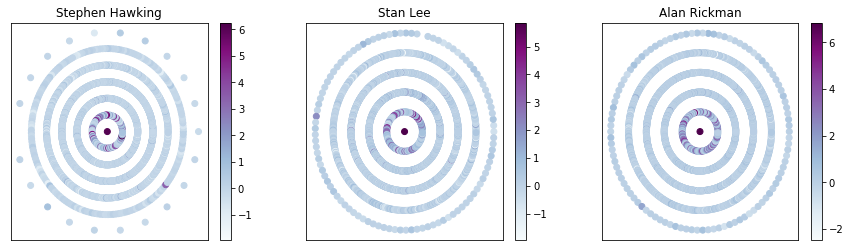

In [14]:
plt.figure(figsize=(15,4))
for i,(article, dist, signal) in enumerate(zip(articles, distances, signals)):
    points, labels = assign_coordinates_colours(hop_map(dist), signal)
    plt.subplot(1,3,i+1)
    sc = plt.scatter(points[:,0], points[:,1], c=np.log(labels), cmap=pylab.cm.BuPu)
    plt.colorbar(sc)
    plt.yticks([]); plt.xticks([])
    plt.title(article)
plt.savefig(os.path.join(plots_folder, 'signal_scatter.pdf'), bbox_inches='tight')

### Section 2: Exploring the signal 

In [15]:
nodes_arr = [np.array(G.nodes()) for G in graphs]
signals_arr = [np.array([s[n] for n in G.nodes()]) for G,s in zip(graphs, signals)]
nodes_arr, signals_arr

([array(['Stephen Hawking', 'Scientific American', 'Jim Al-Khalili', ...,
         "state's attorney", 'post office', 'disorderly conduct'],
        dtype='<U72'),
  array(['Stan Lee', 'Marvel Cinematic Universe', 'BBC Four', ...,
         'Jason Durr', 'The Mystery of the Blue Train',
         'Outline of nutrition'], dtype='<U97'),
  array(['Alan Rickman', 'Irish Independent', 'Dublin', ..., 'payola',
         'Jennifer Lopez', 'The Ghan'], dtype='<U89')],
 [array([451.57049617,   1.08369099,   4.15853659, ...,   1.        ,
           1.        ,   1.        ]),
  array([347.05108962,   1.71901709,   0.87118644, ...,   0.62240664,
           0.42146597,   0.90625   ]),
  array([926.31277293,   1.1954023 ,   1.00352973, ...,   1.        ,
           1.25574893,   0.93574297])])

In [16]:
signals_arr[0][nodes_arr[0] == 'Stan Lee']

array([], dtype=float64)

In [17]:
# Top 5 pages with biggest increase in views
for article, nodes, signal in zip(articles, nodes_arr, signals_arr):
    indices = np.flip(np.argsort(signal))
    print(f'{article} graph:')
    for node, views in zip(nodes[indices][0:6], signal[indices][0:6]):
        print(f'{node}: {views:.2f} times more views')
    print()

Stephen Hawking graph:
University College Boat Club (Oxford): 516.00 times more views
Stephen Hawking: 451.57 times more views
Lucasian Professor of Mathematics: 268.66 times more views
St Albans School, Hertfordshire: 180.43 times more views
Keep Talking: 153.22 times more views
God Created the Integers: 116.60 times more views

Stan Lee graph:
Stan Lee: 347.05 times more views
List of comics creators appearing in comics: 106.86 times more views
Bullpen Bulletins: 82.43 times more views
Bill Everett: 76.97 times more views
Don Heck: 58.83 times more views
Martin Goodman (publisher): 42.63 times more views

Alan Rickman graph:
Alan Rickman: 926.31 times more views
Truly, Madly, Deeply: 382.86 times more views
My Name Is Rachel Corrie: 154.50 times more views
Tom Burke (actor): 123.02 times more views
Eye in the Sky (2015 film): 66.47 times more views
Adam Leonard (singer-songwriter): 52.00 times more views



Note that for the "Stephen Hawking" graph there is another page "University College Boat Club (Oxford)" with higher increase in number of views!
Let's investigate...

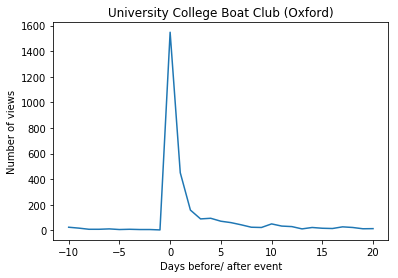

In [18]:
import datetime
from helpers import page_visits

article, datestr = 'University College Boat Club (Oxford)', '2018-03-14'

ndaysbefore = 10
ndaysafter = 20

date = datetime.datetime.strptime(datestr, '%Y-%m-%d')
start = date - datetime.timedelta(days=ndaysbefore)
end = date + datetime.timedelta(days=ndaysafter)

views = page_visits.getUserActivity(article=article,
                        granularity="daily",
                        start=start,
                        end=end,
                        dateformat="iso")

y = [x[0] for x in views]
x = np.arange(-ndaysbefore, ndaysafter+1)
plt.plot(x, y)
plt.xlabel('Days before/ after event')
plt.ylabel('Number of views')
plt.title(article);

Ok, it's just that the page had basically 0 views before the event...

#### Let's have a closer look at the views signal

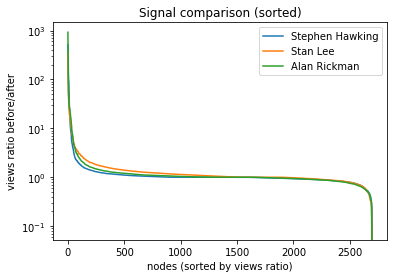

In [19]:
#plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
for i, (article, signal) in enumerate(zip(articles, signals_arr)):
    plt.semilogy(sorted(signal, reverse=True), label=article)
plt.legend()
plt.ylabel('views ratio before/after')
plt.xlabel('nodes (sorted by views ratio)')
plt.title('Signal comparison (sorted)');

In [20]:
# TODO: not sure if we keep this
'''
plt.figure(figsize=(10,8))
plt.subplots_adjust(hspace=0.3)
for i, (article, signal) in enumerate(zip(articles, signals_arr)):
    plt.subplot(3,2,2*i+1)
    plt.plot(signal)
    plt.title(article)
    plt.subplot(3,2,2*i+2)
    plt.semilogy(sorted(signal, reverse=True))
    plt.title(article)
''';

In [21]:
# make graph adjacency undirected & remove self loops
laplacian_comb = []
graphs_pygsp = []
for G in graphs:
    A = nx.adjacency_matrix(G).todense()
    A = np.logical_or(A, A.T).astype(int)
    np.fill_diagonal(A, 0)
    A = np.array(A)
    D = np.diag(np.sum(A, axis=0))
    L = D - A
    laplacian_comb.append(L)
    G = pygsp.graphs.Graph(sparse.csr_matrix(A), lap_type='normalized')
    graphs_pygsp.append(G)

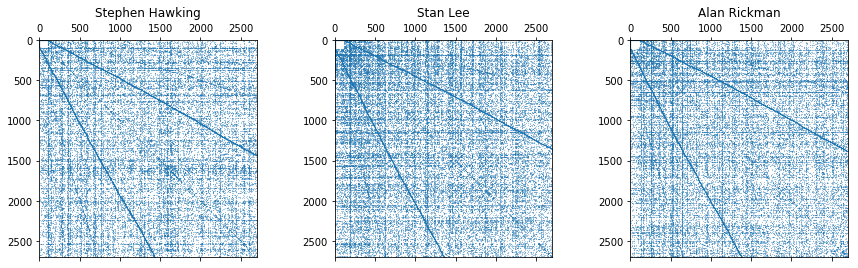

In [22]:
plt.figure(figsize=(15,4))
for i, (article, Gpygsp) in enumerate(zip(articles, graphs_pygsp)):
    plt.subplot(1,3,i+1)
    plt.spy(Gpygsp.W, markersize=0.1)
    plt.title(article, y=1.08)

In [23]:
eigenmaps = []
for G in graphs_pygsp:
    eig_val, U = sparse.linalg.eigsh(G.L, k=3, which='SM')
    eigenmaps.append(U[:,1:3])

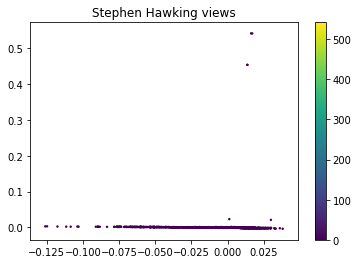

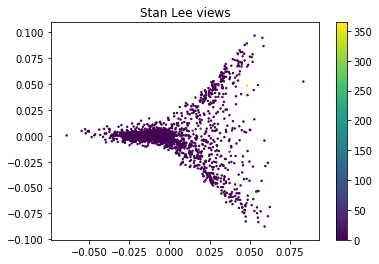

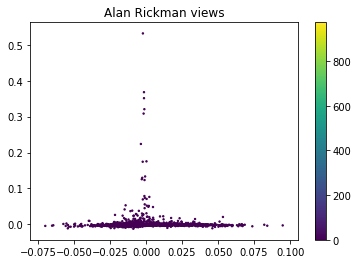

In [24]:
for i, G in enumerate(graphs_pygsp):
    G.set_coordinates(eigenmaps[i])
    G.plot_signal(signals_arr[i], vertex_size=2, show_edges=False, plot_name=articles[i]+' views')

The eigenmaps don't are not ideal for the "Stephen Hawking" and "Alan Rickman" graphs.

### Section 2: SP on the signal 

In [25]:
def GFT(U, x):
    return  np.matmul(U.T,x) # U.T= U^-1 because orthonormal 

def iGFT(U, x):
    return np.matmul(U,x) 

def heat_kernel(e, t):
    return np.exp(-t*e)

def inverse_kernel(e, t):
    g = 1/(1 + t*e)
    return g

def rectangle_kernel(e, l_min, l_max):
    cond = np.logical_and(e >= l_min, e <= l_max)
    return np.where(cond, 1, 0)

def graph_filter(x, U, e, kernel, **kwargs):
    '''
    x: signal
    U: eigenvectors
    e: eigenvalues
    kernel: kernel function
    kwargs: kernel function arguments
    '''
    g = kernel(e, **kwargs)
    return iGFT(U, np.matmul(np.diag(g),GFT(U, x)))

In [26]:
eigvals, eigvecs = [], []
for article, L in zip(articles, laplacian_comb):
    file = os.path.join(data_folder, article_to_filename(article)+'_eigen_decomposition.npz')
    e, U = np.linalg.eigh(L)
#    print(f'saving {file}')
#    np.savez(file, e=e, U=U)
    eigvals.append(e)
    eigvecs.append(U)

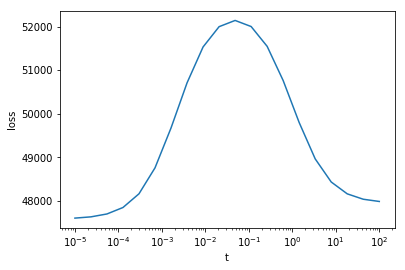

In [111]:
# try to find an optimal paramter t
def L1(x, y): return np.sum(np.abs(x-y))
def L2(x, y): return np.sum((x-y)**2)

def find_param(e, U, signal, dirac, kernel, t_range, loss_fn):
    loss = [loss_fn(signal, graph_filter(dirac, U, e, kernel, t=t)) for t in t_range]

    plt.semilogx(t_range, loss)
    plt.xlabel('t')
    plt.ylabel('loss')
    plt.show()
    t = t_range[np.argmin(loss)]
    out = graph_filter(dirac, U, e, kernel, t=t)
    return t, out

    
signals_heat_kernel = []
signals_inverse_kernel = []
for i, article in enumerate(articles):
    dirac = 1*np.ones(len(nodes_arr[i]));
    root_amplitude = signals_arr[i][nodes_arr[i] == article][0]
    dirac[nodes_arr[i]==article] = root_amplitude;

    t_range = np.logspace(-5, 2, 20)
    t, inverse = find_param(dirac, eigvecs[i], eigvals[i], signals_arr[i], inverse_kernel, t_range, L1)
    signals_inverse_kernel.append(inverse)
    break
    

In [75]:
signals_heat_kernel = []
signals_inverse_kernel = []
for i, article in enumerate(articles):
    dirac = 1*np.ones(len(nodes_arr[i]));
    root_amplitude = signals_arr[i][nodes_arr[i] == article][0]
    dirac[nodes_arr[i]==article] = root_amplitude;

    heat = graph_filter(dirac, eigvecs[i], eigvals[i], heat_kernel, t=0.1)
    signals_heat_kernel.append(heat)

    inverse = graph_filter(dirac, eigvecs[i], eigvals[i], inverse_kernel, t=0.1)
    signals_inverse_kernel.append(inverse)

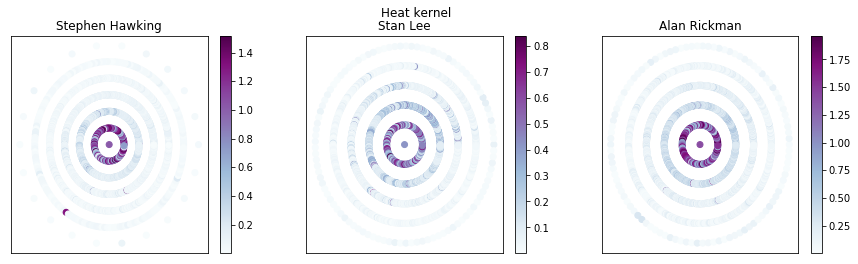

In [76]:
plt.figure(figsize=(15,4))
for i, article in enumerate(articles):
    signal = dict(zip(nodes_arr[i], signals_heat_kernel[i]))
    points, labels = assign_coordinates_colours(hop_map(distances[i]), signal)
    plt.subplot(1,3,i+1)
    sc = plt.scatter(points[:,0], points[:,1], c=np.log(labels), cmap=pylab.cm.BuPu)
    plt.colorbar(sc)
    plt.yticks([]); plt.xticks([])
    plt.title(article)
plt.suptitle('Heat kernel');
#plt.savefig(os.path.join(plots_folder, 'heat_scatter.pdf'), bbox_inches='tight')

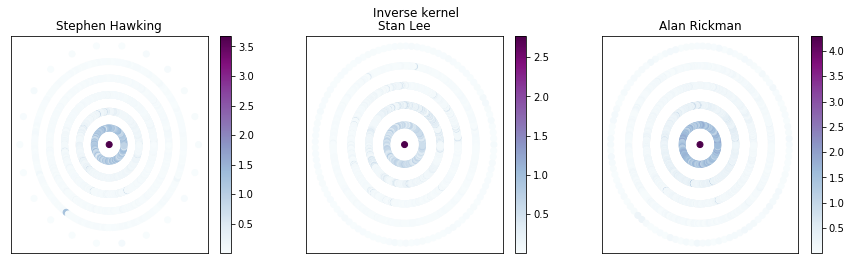

In [77]:
plt.figure(figsize=(15,4))
for i, article in enumerate(articles):
    signal = dict(zip(nodes_arr[i], signals_inverse_kernel[i]))
    points, labels = assign_coordinates_colours(hop_map(distances[i]), signal)
    plt.subplot(1,3,i+1)
    sc = plt.scatter(points[:,0], points[:,1], c=np.log(labels), cmap=pylab.cm.BuPu)
    plt.colorbar(sc)
    plt.yticks([]); plt.xticks([])
    plt.title(article)
plt.suptitle('Inverse kernel');
#plt.savefig(os.path.join(plots_folder, 'heat_scatter.pdf'), bbox_inches='tight')

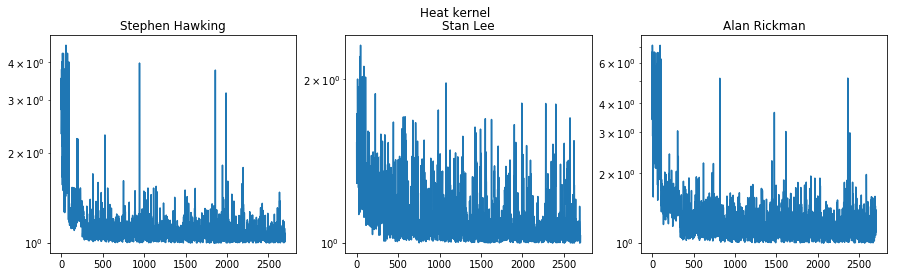

In [78]:
plt.figure(figsize=(15,4))
for i, article in enumerate(articles):
    plt.subplot(1,3,i+1)
    plt.semilogy(signals_heat_kernel[i])
    plt.title(article)
plt.suptitle('Heat kernel');

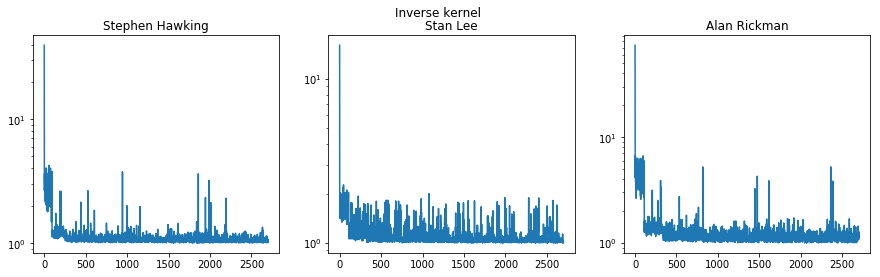

In [79]:
plt.figure(figsize=(15,4))
for i, article in enumerate(articles):
    plt.subplot(1,3,i+1)
    plt.semilogy(signals_inverse_kernel[i])
    plt.title(article)
plt.suptitle('Inverse kernel');

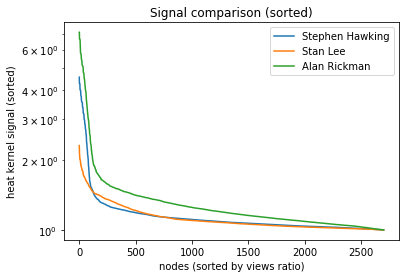

In [80]:
for i, article in enumerate(articles):
    plt.semilogy(sorted(signals_heat_kernel[i], reverse=True), label=article)
plt.legend()
plt.ylabel('heat kernel signal (sorted)')
plt.xlabel('nodes (sorted by views ratio)')
plt.title('Signal comparison (sorted)');

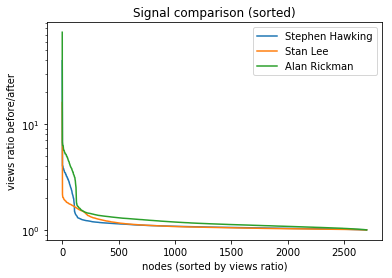

In [81]:
for i, article in enumerate(articles):
    plt.semilogy(sorted(signals_inverse_kernel[i], reverse=True), label=article)
plt.legend()
plt.ylabel('views ratio before/after')
plt.xlabel('nodes (sorted by views ratio)')
plt.title('Signal comparison (sorted)');